In [27]:
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

from IPython.display import IFrame

import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

from IPython.core.display import display, HTML

In this notebook I try to analyze: 
How to evaluate company’s growth by applying predictive modeling and learning from customers previous behaviors? 
In order to do so I look at different metrics. This metric depends on company’s product, position, targets & more. I use a sample dataset of an online retail. For purpose of this project I decidec to evaluate monthly Revenue as a key metric! Lets do it...

In [28]:
df = pd.read_csv('OnlineRetail.csv', encoding = 'unicode_escape' )

In [29]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
521400,580366,22624,IVORY KITCHEN SCALES,1,12/2/2011 16:38,8.50,NaN,United Kingdom
511658,579508,22585,PACK OF 6 BIRDY GIFT TAGS,19,11/29/2011 16:33,2.46,NaN,United Kingdom
533103,581011,22600,CHRISTMAS RETROSPOT STAR WOOD,12,12/7/2011 9:22,0.85,14397.0,United Kingdom
92707,544203,20726,LUNCH BAG WOODLAND,10,2/17/2011 10:30,1.65,12362.0,Belgium
388672,570448,85152,HAND OVER THE CHOCOLATE SIGN,12,10/10/2011 14:55,2.10,13224.0,United Kingdom


In [30]:
df.shape

(541909, 8)

This dataframe contains 8 variables that correspond to:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [32]:
#dropping all the null values 
df.dropna(inplace=True)

In [33]:
#dropping duplicate values 
df.drop_duplicates(inplace=True)
df.shape

(401604, 8)

We removed all the duplicates and null values, you can see below that there is not Null values 

In [34]:
df['Country'].value_counts()

United Kingdom          356728
Germany                   9480
France                    8475
EIRE                      7475
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1471
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     247
Unspecified                241
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [35]:
#most sale is happining in UK so lets focus on UK for now
df = df.loc[df["Country"] =='United Kingdom'].reset_index(drop=True)

On quatity column some value is negative and that is not possible, because customer can't order negative order 

In [36]:
#so we should remove negative values from 'Quantity' 
df = df[df['Quantity'] > 0] 

In [37]:
#converting the InvoiceDate from string to dataframe 

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [38]:
#the object datatype now turned into dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 356727
Data columns (total 8 columns):
InvoiceNo      349227 non-null object
StockCode      349227 non-null object
Description    349227 non-null object
Quantity       349227 non-null int64
InvoiceDate    349227 non-null datetime64[ns]
UnitPrice      349227 non-null float64
CustomerID     349227 non-null float64
Country        349227 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.0+ MB


In [39]:
#only care about the year and month so removing date, hour and min from datetime
# df['YearDate'] = df['InvoiceDate'].apply(lambda x: datetime(x.year, x.month, 1))

df['YearDate'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)


In [40]:
df.YearDate.tail(3)

356725    201112
356726    201112
356727    201112
Name: YearDate, dtype: int64

In [41]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


In [42]:
df.shape

(349227, 9)

Now it is time to pick our north star metric:

A north star metric is the key measure of success for the product team in a company. It defines the relationship between the customer problems that the product team is trying to solve and the revenue that the business aims to generate by doing so... 

for this project I pick monthly revenue as a north metirc start...lets calculate revenue below 

# Monthly Revenue

#### Revenue = No. of Units Sold('Quantity') x Average Price('UnitPrice')

In [53]:
df['Revenue'] = df['UnitPrice'] * df['Quantity']

In [54]:
df_revenue = df.groupby(['YearDate'])['Revenue'].sum().reset_index()
df_revenue.head(5)

,YearDate,Revenue
0,201012,496477.340
1,201101,440876.330
2,201102,354618.200
3,201103,465784.190
4,201104,408733.111


In [55]:
plot_data = [
    go.Scatter(
        x=df_revenue['YearDate'],
        y=df_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )

In [58]:
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# pyoff.iplot(fig, filename = 'figure_1.html')
# display(HTML('figure_1.html'))

In [59]:
IFrame(src='./temp-plot.html', width=1000, height=700)

As you can see above month of December does not show the entire month as a result I remove it from data!

In [60]:
#Month of Decmber does not cover the whole month so I won't use month of December 2011 in the evaluation
df = df.loc[df['YearDate'] != 201112]
df.shape

(333704, 10)

In [61]:
df_revenue = df.groupby(['YearDate'])['Revenue'].sum().reset_index()
df_revenue

,YearDate,Revenue
0,201012,496477.340
1,201101,440876.330
2,201102,354618.200
3,201103,465784.190
4,201104,408733.111
5,201105,550359.350
6,201106,523775.590
7,201107,484545.591
8,201108,497194.910
9,201109,794806.692


In [65]:
plot_data = [
    go.Scatter(
        x=df_revenue['YearDate'],
        y=df_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )

In [68]:
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [67]:
IFrame(src='./temp-plot.html', width=1000, height=700)

Now you can see as December 2011 deleted we have a better understanding of the revenue. 

Revenue went up from Auguest onward. 

Month of December 2010 is the month that the business either acquired customers or it is from the time we have the data

Month Jan and Feb Revenue went down which makes sense if the business acquired customers so no time to see return in investment yet however month March the revenuw went up and again down in April and we need to study more to find out what happend in April that the revenue went down  

### percentage of growth = percentage of change in revenue

In [69]:
df_revenue['pct_growth'] = df_revenue['Revenue'].pct_change()
df_revenue.head(5)

,YearDate,Revenue,pct_growth
0,201012,496477.340,NaN
1,201101,440876.330,-0.111991
2,201102,354618.200,-0.195652
3,201103,465784.190,0.313481
4,201104,408733.111,-0.122484


In [70]:
plot_data = [
    go.Scatter(
        x=df_revenue['YearDate'],
        y=df_revenue['pct_growth'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Percentage Monthly Growth'
    )

In [71]:
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)

'temp-plot.html'

In [72]:
IFrame(src='./temp-plot.html', width=1000, height=700)

the growth rate went down in Jan, Feb, April, June, July
the growth rate went up by 59 percent in Sep

In [585]:
pickle.dump(df, open("Data_Exploration.pkl", "wb" ))

Lets look at UK and evaluate the customers in UK

In [586]:
df_UK = df.groupby('YearDate')['CustomerID'].nunique().reset_index()

<Figure size 1440x720 with 0 Axes>

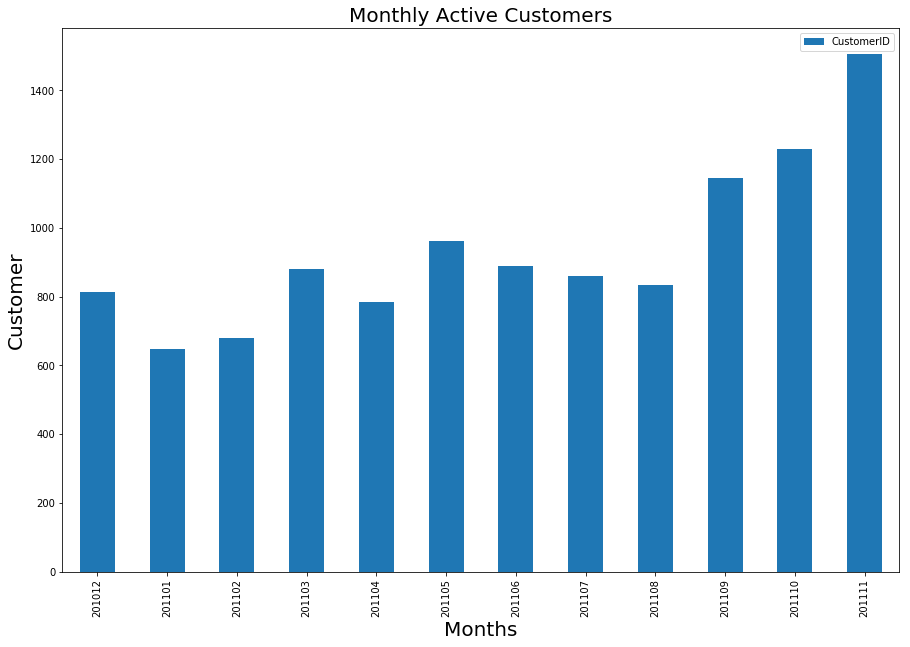

In [587]:
#monthly active users in UK
plt.figure(figsize=(20,10));
df_UK.plot(kind= "bar", x = "YearDate",y ="CustomerID", figsize=(15,10));
plt.title('Monthly Active Customers', fontsize=20)
plt.xlabel("Months", fontsize=20)
plt.ylabel("Customer", fontsize=20);

In [589]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearDate,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,201012,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,201012,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,201012,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,201012,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,201012,54.08


# Monthly Order Count

In [594]:
monthly_order = df.groupby('YearDate')['Quantity'].sum().reset_index()
monthly_order.head(5)

,YearDate,Quantity
0,201012,266577
1,201101,277699
2,201102,212808
3,201103,275426
4,201104,259594


In [595]:
plot_data = [
    go.Bar(
        x=monthly_order['YearDate'],
        y=monthly_order['Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Total # of Order'
    )

In [596]:
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)

'temp-plot.html'

In [597]:
IFrame(src='./temp-plot.html', width=1000, height=800)

In [598]:
monthly_order['Quantity'].mean()

332838.8333333333

# Average Revenue per Order

In [609]:
average_order_revenue = df.groupby('YearDate')['Revenue'].mean().reset_index()
average_order_revenue.head(5)

,YearDate,Revenue
0,201012,21.163619
1,201101,24.601101
2,201102,20.218838
3,201103,19.644224
4,201104,19.786664


In [610]:
plot_data = [
    go.Scatter(
        x=average_order_revenue['YearDate'],
        y=average_order_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Average Revenue Per Order'
    )

In [611]:
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)

'temp-plot.html'

In [612]:
IFrame(src='./temp-plot.html', width=1000, height=700)

By just looking at the graphs we can say that the the business is sticking well, however the business is not doing enough to acquired more customer. Lets evaluate more... we start by calculating new and exisiting customers. 

# New Customer 

In [624]:
first_purchase = df.groupby('CustomerID').YearDate.min().reset_index()

In [625]:
first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']

In [626]:
df = pd.merge(df, first_purchase, on='CustomerID')

In [627]:
df['UserType'] = 'New'
df.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearDate,Revenue,FirstPurchaseDate,UserType
174128,544837,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,3,2011-02-24 10:29:00,2.95,15910.0,United Kingdom,201102,8.85,201101,New
120343,542725,22701,PINK DOG BOWL,2,2011-01-31 15:05:00,2.95,16191.0,United Kingdom,201101,5.90,201012,New
316533,571226,22577,WOODEN HEART CHRISTMAS SCANDINAVIAN,24,2011-10-14 13:49:00,0.29,13006.0,United Kingdom,201110,6.96,201110,New


# Existing customers

In [628]:
df.loc[df['YearDate'] > df['FirstPurchaseDate'], 'UserType'] = 'Existing'

In [629]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearDate,Revenue,FirstPurchaseDate,UserType
327669,575891,23469,CARD HOLDER LOVE BIRD SMALL,6,2011-11-11 14:12:00,4.15,15692.0,United Kingdom,201111,24.90,201111,New
49452,546417,22899,CHILDREN'S APRON DOLLY GIRL,10,2011-03-13 10:48:00,2.10,14800.0,United Kingdom,201103,21.00,201012,Existing
179106,566561,22969,HOMEMADE JAM SCENTED CANDLES,12,2011-09-13 12:13:00,1.45,18145.0,United Kingdom,201109,17.40,201101,Existing
9709,544819,40016,CHINESE DRAGON PAPER LANTERNS,12,2011-02-23 17:15:00,0.42,12748.0,United Kingdom,201102,5.04,201012,Existing
284964,577106,22338,STAR DECORATION PAINTED ZINC,4,2011-11-17 17:18:00,0.19,14456.0,United Kingdom,201111,0.76,201107,Existing


In [630]:
df.UserType.value_counts()

Existing    230853
New         102851
Name: UserType, dtype: int64

In [631]:
pickle.dump(df, open("Data_Exploration.pkl", "wb" ) )

In [632]:
df = pickle.load(open("Data_Exploration.pkl", 'rb'))

In [633]:
#calculting the revenue per month for both exiting and new customers 

Revenue_per_type = df.groupby(['YearDate', 'UserType'])['Revenue'].sum().reset_index()

In [634]:
#removing December from both 2010 and 2011
Revenue_per_type  = Revenue_per_type[(Revenue_per_type["YearDate"] != 201012)]
Revenue_per_type

,YearDate,UserType,Revenue
1,201101,Existing,199116.690
2,201101,New,241759.640
3,201102,Existing,219000.380
4,201102,New,135617.820
5,201103,Existing,295924.110
6,201103,New,169860.080
7,201104,Existing,298686.160
8,201104,New,110046.951
9,201105,Existing,455665.250
10,201105,New,94694.100


In [635]:
#plot the graph for total sale between new and existing customers

In [638]:
plot_data = [
    go.Scatter(
        x=Revenue_per_type.query("UserType == 'Existing'")['YearDate'],
        y=Revenue_per_type.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=Revenue_per_type.query("UserType == 'New'")['YearDate'],
        y=Revenue_per_type.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)

'temp-plot.html'

In [637]:
IFrame(src='./temp-plot.html', width=1000, height=700)

In [375]:
# x1 = User_total_sale.query("UserType == 'New'")['YearDate']
# y1 = User_total_sale.query("UserType == 'New'")['Revenue']
# x2 = User_total_sale.query("UserType == 'Existing'")['YearDate']
# y2 = User_total_sale.query("UserType == 'Existing'")['Revenue']

# plt.figure(figsize=(20,10));
# plt.plot(x1, y1, 'r--',  x2, y2 , 'green')
# plt.title('Exisitng Customers vs. New Customers', fontsize=20)
# plt.xlabel("Months", fontsize=20)
# plt.ylabel("Revenue", fontsize=20)
# plt.legend(('New', 'Exisitng'),fontsize=20);

We can see that in January the business acquired new customers and the business is sticking very well and the retention rate is good. However the business is not acquiring new customers and need to be evaluated why the acquisition is going down 

In [648]:
df_new = df.loc[df['UserType'] == 'New'].groupby(['YearDate'])['CustomerID'].nunique()
df_new

YearDate
201012    815
201101    358
201102    340
201103    419
201104    277
201105    256
201106    214
201107    169
201108    141
201109    276
201110    324
201111    298
Name: CustomerID, dtype: int64

In [649]:
df_existing = df.loc[df['UserType'] == 'Existing'].groupby(['YearDate'])['CustomerID'].nunique()
df_existing

YearDate
201101     289
201102     339
201103     461
201104     507
201105     706
201106     675
201107     690
201108     693
201109     870
201110     906
201111    1208
Name: CustomerID, dtype: int64

In [650]:
df_user_ratio = df_new/df_existing
df_user_ratio

YearDate
201012         NaN
201101    1.238754
201102    1.002950
201103    0.908894
201104    0.546351
201105    0.362606
201106    0.317037
201107    0.244928
201108    0.203463
201109    0.317241
201110    0.357616
201111    0.246689
Name: CustomerID, dtype: float64

In [651]:
df_user_ratio = df_user_ratio.dropna()

In [652]:
df_user_ratio

YearDate
201101    1.238754
201102    1.002950
201103    0.908894
201104    0.546351
201105    0.362606
201106    0.317037
201107    0.244928
201108    0.203463
201109    0.317241
201110    0.357616
201111    0.246689
Name: CustomerID, dtype: float64

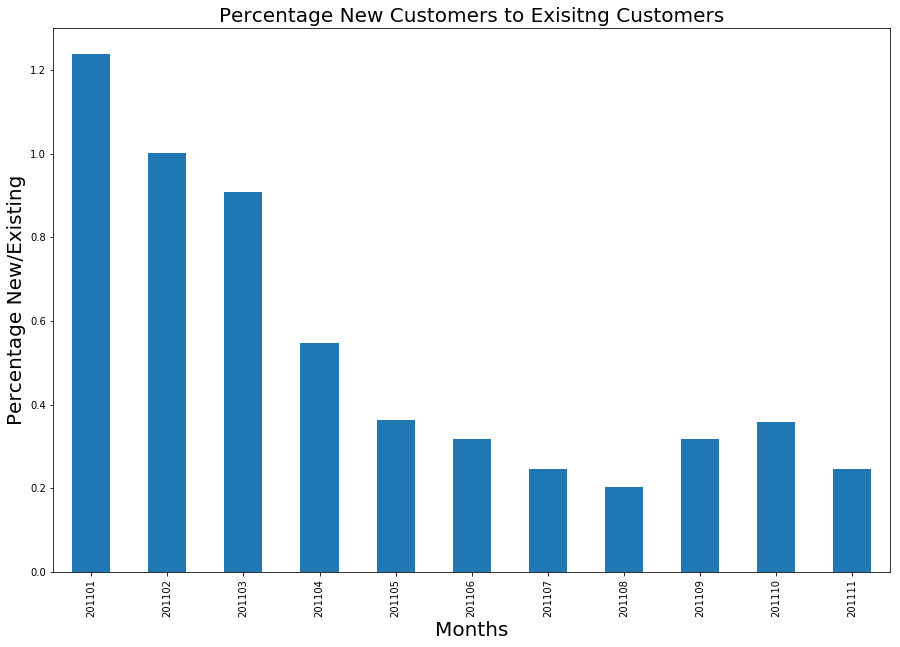

In [653]:
plt.figure(figsize=(20,10));
df_user_ratio.plot(kind= "bar", x = "YearDate",y ="CustomerID", figsize=(15,10));
plt.title('Percentage New Customers to Exisitng Customers', fontsize=20)
plt.xlabel("Months", fontsize=20)
plt.ylabel("Percentage New/Existing", fontsize=20);

New customers ratio has decline, in Janaury, Feb, and March the new customers ratio was high but by time it declined

# Monthly Retention Rate

In [654]:
df_user_purchase = df.groupby(['YearDate','CustomerID'])['Revenue'].sum().astype(int).reset_index()
df_user_purchase.sample(10)

,YearDate,CustomerID,Revenue
2949,201103,17799.0,264
2351,201103,14083.0,14
9268,201110,16184.0,172
2071,201102,17735.0,847
6257,201107,16672.0,585
8226,201109,16906.0,166
8765,201110,14057.0,435
11049,201111,17624.0,443
10143,201111,14397.0,593
2459,201103,14693.0,172


In [655]:
df_retention = pd.crosstab(df_user_purchase['CustomerID'], df_user_purchase['YearDate']).reset_index()
df_retention.head(10)

YearDate,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0
5,12821.0,0,0,0,0,0,1,0,0,0,0,0,0
6,12822.0,0,0,0,0,0,0,0,0,0,1,0,0
7,12823.0,0,0,1,1,0,0,0,0,1,1,0,0
8,12824.0,0,0,0,0,0,0,0,0,0,0,1,0
9,12826.0,1,1,0,0,0,0,1,0,0,1,0,1


In [656]:
months = df_retention.columns[2:]
months

Index([201101, 201102, 201103, 201104, 201105, 201106, 201107, 201108, 201109,
       201110, 201111],
      dtype='object', name='YearDate')

In [657]:
retention_array = []
for i in range(len(months) - 1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['YearDate'] = int(selected_month)
    retention_data['TotalUser'] = df_retention[selected_month].sum()
    retention_data['RetainedUser'] = df_retention[(df_retention[selected_month] > 0) & (df_retention[prev_month] > 0)][selected_month].sum()
    retention_array.append(retention_data)

In [658]:
df_retention = pd.DataFrame(retention_array)

In [660]:
df_retention.head(5)

,RetainedUser,TotalUser,YearDate
0,233,679,201102
1,254,880,201103
2,274,784,201104
3,340,962,201105
4,368,889,201106


In [661]:
df_retention['RetentionRate'] = df_retention['RetainedUser']/df_retention['TotalUser']

In [662]:
df_retention.head(5)

,RetainedUser,TotalUser,YearDate,RetentionRate
0,233,679,201102,0.343152
1,254,880,201103,0.288636
2,274,784,201104,0.349490
3,340,962,201105,0.353430
4,368,889,201106,0.413948


In [663]:
plot_data = [
    go.Scatter(
        x=df_retention['YearDate'],
        y=df_retention['RetentionRate'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Retention Rate'
    )


fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)


IFrame(src='./temp-plot.html', width=1000, height=700)

# Churn Rate

In [664]:
df_retention['ChurnRate'] = 1 - df_retention['RetentionRate']

In [665]:
plot_data = [
    go.Scatter(
        x=df_retention['YearDate'],
        y=df_retention['ChurnRate'],
        name="organic"
    )
    
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Churn Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.plot(fig)

IFrame(src='./temp-plot.html', width=1000, height=700)

In [500]:
#Monthly revenue for each customer

# user_purchase = df.groupby(['CustomerID','YearDate'])['Revenue'].sum().astype(int).reset_index()
# user_purchase.head()

In [201]:
# user_purchase['YearDate'] = user_purchase['YearDate'].map(lambda x: 100*x.year + x.month)

In [501]:
pickle.dump(df, open("Data_Exploration.pkl", "wb" ) )